In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/training.csv
./kaggle/input/solution.csv
./kaggle/input/higgs_boson_data.csv
./kaggle/input/random_submission.csv
./kaggle/input/test.csv
./kaggle/input/HiggsBosonCompetition_AMSMetric_rev1.py
./kaggle/input/data_splitter.py


In [28]:
!pip install keras==2.15.0
import keras
print(keras.version)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate,GRU,Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import FixedLenFeature
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, normalize

  Obtaining dependency information for keras==2.15.0 from https://files.pythonhosted.org/packages/fc/a7/0d4490de967a67f68a538cc9cdb259bff971c4b5787f7765dc7c8f118f71/keras-2.15.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.6.0
    Uninstalling keras-3.6.0:
      Successfully uninstalled keras-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.2 requires keras>=3.0.0, but you have keras 2.15.0 which is incompatible.
<function version at 0x147fc2660>


In [29]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.2


In [30]:
try: 
     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
     strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
     strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [31]:
AUTO = tf.data.experimental.AUTOTUNE

In [32]:
train_df = pd.read_csv('./kaggle/input/training.csv')
test_df = pd.read_csv('./kaggle/input/test.csv')

print(train_df.shape,test_df.shape)

(250000, 33) (550000, 31)


In [33]:
list(set(train_df.columns ) - set(test_df.columns))

['Label', 'Weight']

In [34]:
train_df.drop(['Weight'], axis=1,inplace=True)

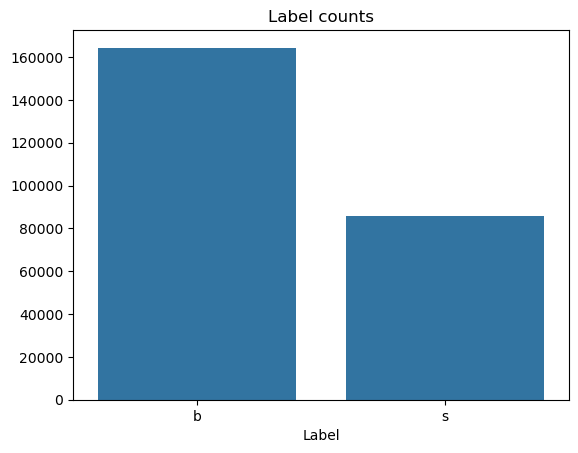

In [35]:
sns.barplot(x = train_df['Label'].value_counts().index, y = train_df['Label'].value_counts().values)
plt.title('Label counts')
plt.show()

In [36]:
enc = LabelEncoder()

train_df['Label'] = enc.fit_transform(train_df['Label'])
train_df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,1
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,0
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,0


In [37]:
train_df.set_index(['EventId'],inplace = True)
test_df.set_index(['EventId'],inplace = True)

In [38]:
X = train_df.drop(['Label'], axis=1)
y = train_df['Label'].values

In [39]:
X = normalize(X)
test_df_nor = normalize(test_df)

In [40]:
splitter=StratifiedShuffleSplit(n_splits=1,random_state=12)

for train,test in splitter.split(X,y):     #this will splits the index
    X_train_SS = X[train]
    y_train_SS = y[train]
    X_test_SS = X[test]
    y_test_SS = y[test]

In [41]:
# reshape for rnn
X_train_SS = np.reshape(X_train_SS, (X_train_SS.shape[0],X_train_SS.shape[1],1))
X_test_SS = np.reshape(X_test_SS, (X_test_SS.shape[0],X_test_SS.shape[1],1))

In [42]:
X_train_SS.shape[2]

1

In [61]:
def build_Lstm_model(train_x,train_y,test_x,test_y):
    inp = Input(shape=(train_x.shape[1],train_x.shape[2]))
    rnn_1st_model = LSTM(units=60, return_sequences=True,recurrent_dropout=0.1)(inp)
    rnn_2nd_model = LSTM(units=60,recurrent_dropout=0.1)(rnn_1st_model)
    dense_layer = Dense(128)(rnn_2nd_model)
    drop_out = Dropout(0.2)(dense_layer)
    output = Dense(1, activation= LeakyReLU(alpha=0.1),name="class")(drop_out)
    model = Model(inp, output)
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_LSTM.h5.keras', monitor='val_loss', save_best_only=True)]
    model.summary()
    model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError()],
                        metrics=[tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")
    history = model.fit(train_x, train_y, 
          epochs = 20, 
          batch_size = 128, 
          validation_data=(test_x,  test_y), 
          callbacks=callbacks)
    return history,model

In [78]:
def build_Gru_model(train_x,train_y,test_x,test_y):
    inp = Input(shape=(train_x.shape[1],train_x.shape[2]))
    rnn_1st_model = GRU(units=60, return_sequences=True,recurrent_dropout=0.1)(inp)
    rnn_2nd_model = GRU(units=60,recurrent_dropout=0.1)(rnn_1st_model)
    dense_layer = Dense(128)(rnn_2nd_model)
    drop_out = Dropout(0.25)(dense_layer)
    output = Dense(1, activation= LeakyReLU(alpha=0.1),name="class")(drop_out)
    model = Model(inp, output)
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_GRU.keras', monitor='val_loss', save_best_only=True)]
    model.summary()
    model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError()],
                        metrics=[tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")
    history = model.fit(train_x, train_y, 
          epochs = 20, 
          batch_size = 128, 
          validation_data=(test_x,  test_y), 
          callbacks=callbacks)
    return history,model

In [74]:
def plot_Loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    for idx, value in enumerate(history.history['loss']):
        print(f"Epoch {idx + 1}: Loss = {value}")
    print('validation: \n')
    for idx, value in enumerate(history.history['val_loss']):
        print(f"Epoch {idx + 1}: Loss = {value}")


In [69]:
def Save_Result_To_Csv(model,model_name,csv_file):
    test_pre = np.reshape(test_df_nor, (test_df_nor.shape[0],test_df_nor.shape[1],1))
    model.load_weights(model_name)
    prediction = model.predict(test_pre)
    prediction =  np.where(prediction > 0.5, 1, 0)
    prediction = pd.Series(prediction[:,0])
    sub = pd.read_csv('./kaggle/input/random_submission.csv')
    test_predict = pd.DataFrame({"EventId":sub['EventId'],"RankOrder":sub['RankOrder'],"Class":prediction})
    test_predict['Class'] = test_predict['Class'].replace(1,'s')
    test_predict['Class'] = test_predict['Class'].replace(0,'b')
    test_predict.to_csv(csv_file,index=False)

In [65]:
history_LSTM,Lstm_model = build_Lstm_model(X_train_SS,y_train_SS,X_test_SS,y_test_SS)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 30, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,857 (202.57 KB)

 Trainable params: 51,857 (202.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 85s 46ms/step - loss: 0.1083 - mean_squared_logarithmic_error: 0.1083 - val_loss: 0.1311 - val_mean_squared_logarithmic_error: 0.1310 - learning_rate: 0.0010
Epoch 2/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 70s 40ms/step - loss: 0.1333 - mean_squared_logarithmic_error: 0.1333 - val_loss: 0.1291 - val_mean_squared_logarithmic_error: 0.1289 - learning_rate: 0.0010
Epoch 3/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 73s 41ms/step - loss: 0.1314 - mean_squared_logarithmic_error: 0.1314 - val_loss: 0.1284 - val_mean_squared_logarithmic_error: 0.1283 - learning_rate: 0.0010
Epoch 4/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 78s 44ms/step - loss: 0.1314 - mean_squared_logarithmic_error: 0.1314 - val_loss: 0.1288 - val_mean_squared_logarithmic_error: 0.1287 - learning_rate: 0.0010
Epoch 5/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - loss: 0.1234 - mean_squared_logarithmic_error: 0.1234 - val_loss: 0.0948 - val_mean_squared_logarithmic_error: 0.0947 - learning_rate: 0.0010


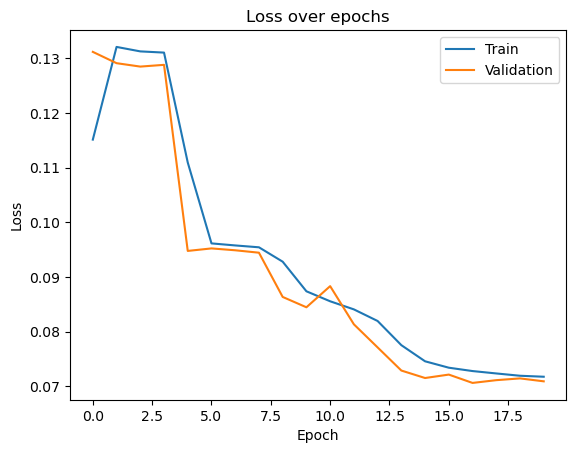

In [66]:
plot_Loss(history_LSTM)

In [70]:
Save_Result_To_Csv(Lstm_model,"best_model_LSTM.h5.keras","submission_LSTM.csv")

17188/17188 ━━━━━━━━━━━━━━━━━━━━ 90s 5ms/step


In [79]:
history_GRU,Gru_model = build_Gru_model(X_train_SS,y_train_SS,X_test_SS,y_test_SS)

/Users/manylya/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 30, 60)         │        11,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 60)             │        21,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,237 (161.08 KB)

 Trainable params: 41,237 (161.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - loss: 0.1069 - mean_squared_logarithmic_error: 0.1069 - val_loss: 0.1079 - val_mean_squared_logarithmic_error: 0.1078 - learning_rate: 0.0010
Epoch 2/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - loss: 0.0973 - mean_squared_logarithmic_error: 0.0973 - val_loss: 0.1004 - val_mean_squared_logarithmic_error: 0.1003 - learning_rate: 0.0010
Epoch 3/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 59s 33ms/step - loss: 0.0950 - mean_squared_logarithmic_error: 0.0950 - val_loss: 0.1186 - val_mean_squared_logarithmic_error: 0.1185 - learning_rate: 0.0010
Epoch 4/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 58s 33ms/step - loss: 0.0922 - mean_squared_logarithmic_error: 0.0922 - val_loss: 0.1138 - val_mean_squared_logarithmic_error: 0.1137 - learning_rate: 0.0010
Epoch 5/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - loss: 0.0889 - mean_squared_logarithmic_error: 0.0889 - val_loss: 0.1161 - val_mean_squared_logarithmic_error: 0.1160 - learning_rate: 0.0010


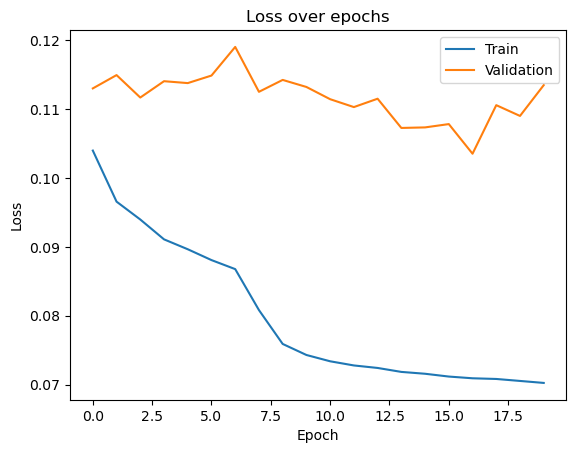

Epoch 1: Loss = 0.10396737605333328
Epoch 2: Loss = 0.09655696153640747
Epoch 3: Loss = 0.09396304190158844
Epoch 4: Loss = 0.09108354896306992
Epoch 5: Loss = 0.08964686095714569
Epoch 6: Loss = 0.08807424455881119
Epoch 7: Loss = 0.08676357567310333
Epoch 8: Loss = 0.08081810921430588
Epoch 9: Loss = 0.07590385526418686
Epoch 10: Loss = 0.07430195808410645
Epoch 11: Loss = 0.07338715344667435
Epoch 12: Loss = 0.07278276979923248
Epoch 13: Loss = 0.07241928577423096
Epoch 14: Loss = 0.07184576243162155
Epoch 15: Loss = 0.07157649099826813
Epoch 16: Loss = 0.07117054611444473
Epoch 17: Loss = 0.07092005759477615
Epoch 18: Loss = 0.0708208978176117
Epoch 19: Loss = 0.07053440064191818
Epoch 20: Loss = 0.0702468752861023
validation: 

Epoch 1: Loss = 0.11299142241477966
Epoch 2: Loss = 0.11492328345775604
Epoch 3: Loss = 0.11166630685329437
Epoch 4: Loss = 0.11403714865446091
Epoch 5: Loss = 0.11376107484102249
Epoch 6: Loss = 0.11485641449689865
Epoch 7: Loss = 0.11901161074638367
Epoch

In [75]:
plot_Loss(history_GRU)